# IMPORT REQUIRED LIBRARIES


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import kagglehub



# Load and preprocess dataset
 Download an animal image classification dataset from Kaggle `(cats, dogs, snakes)`, loads up to `800` images per class, resizes them to `64×64`, normalizes pixel values, and converts labels into `one-hot` encoding. Finally, it flattens the images and splits the dataset into training and testing sets (80/20).

In [7]:

dataset_path = kagglehub.dataset_download("borhanitrash/animal-image-classification-dataset")

dirs = ['cats', 'dogs', 'snakes']
X, y = [], []
img_size = (64, 64)

for i, dir_name in enumerate(dirs):
    dir_path = os.path.join(dataset_path, 'Animals', dir_name)
    paths = sorted(os.listdir(dir_path))[:800]

    for file in paths:
        full_path = os.path.join(dir_path, file)
        try:
            img = cv2.imread(full_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                resized_img = cv2.resize(img, img_size)
                X.append(resized_img)
                y.append(i)
            else:
                print(f"Failed to load {full_path}")
        except Exception as e:
            print(f"Skipped {full_path}: {e}")

X = np.array(X) / 255.0   # normalize
Y = np.array(y).reshape(-1,1)

enc = OneHotEncoder(sparse_output=False)
Y = enc.fit_transform(Y)

X = X.reshape(len(X), -1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Improved Neural Network class
An `Improved Neural Network` class with:

`Architecture`: 2 hidden layers + output layer.

`Activations`: ReLU for hidden layers, Softmax for output.

`Training`: Uses cross-entropy loss with L2 regularization, weight initialization (He initialization), and backpropagation with gradient updates.

`Optimizations`: Accuracy tracking, learning rate decay, and stable softmax.

`Prediction`: Outputs class labels using argmax.

`Equations`:

**Sigmoid**
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
**ReLU:**
$$
\text{ReLU}(x) = \max(0, x)
$$
**Softmax:**
$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}, \quad i = 1, \dots, K
$$


In [ ]:
class ImprovedNeuralNetwork:
    def __init__(self, input_dim, hidden1, hidden2, output_dim, lr=0.01):
        self.lr = lr
        self.W1 = np.random.randn(input_dim, hidden1) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, hidden1))
        self.W2 = np.random.randn(hidden1, hidden2) * np.sqrt(2.0 / hidden1)
        self.b2 = np.zeros((1, hidden2))
        self.W3 = np.random.randn(hidden2, output_dim) * np.sqrt(2.0 / hidden2)
        self.b3 = np.zeros((1, output_dim))

    def relu(self, x, der=False):
        if der:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)

    def sigmoid(self, x, der=False):
        if der:
            return x * (1-x)
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feedForward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.h1 = self.relu(self.z1)
        self.z2 = np.dot(self.h1, self.W2) + self.b2
        self.h2 = self.relu(self.z2)
        self.z3 = np.dot(self.h2, self.W3) + self.b3
        self.out = self.softmax(self.z3)
        return self.out

    def backPropagation(self, X, Y, pred):
        m = X.shape[0]

        # Output layer error
        dZ3 = pred - Y
        dW3 = np.dot(self.h2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m

        # Hidden layer 2 error
        dH2 = np.dot(dZ3, self.W3.T) * self.relu(self.z2, der=True)
        dW2 = np.dot(self.h1.T, dH2) / m
        db2 = np.sum(dH2, axis=0, keepdims=True) / m

        # Hidden layer 1 error
        dH1 = np.dot(dH2, self.W2.T) * self.relu(self.z1, der=True)
        dW1 = np.dot(X.T, dH1) / m
        db1 = np.sum(dH1, axis=0, keepdims=True) / m

        # Update weights with L2 regularization
        reg_lambda = 0.001
        self.W3 -= self.lr * (dW3 + reg_lambda * self.W3)
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * (dW2 + reg_lambda * self.W2)
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * (dW1 + reg_lambda * self.W1)
        self.b1 -= self.lr * db1

    def train(self, X, Y, epochs=1000):
        losses = []
        accuracies = []
        for i in range(epochs):
            pred = self.feedForward(X)
           # Cross-entropy loss with regularization
            reg_loss = 0.001 * (np.sum(self.W1**2) + np.sum(self.W2**2) + np.sum(self.W3**2)) / (2 * X.shape[0])
            loss = -np.mean(np.sum(Y * np.log(pred + 1e-8), axis=1)) + reg_loss
            losses.append(loss)

            # Calculate accuracy
            train_pred = np.argmax(pred, axis=1)
            train_true = np.argmax(Y, axis=1)
            acc = np.mean(train_pred == train_true)
            accuracies.append(acc)

            self.backPropagation(X, Y, pred)

            if i % 100 == 0:
                print(f"Epoch {i}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

                # Learning rate decay
                if i > 0 and i % 500 == 0:
                    self.lr *= 0.1
                    print(f"Reduced learning rate to {self.lr}")

        return losses, accuracies

    def predict(self, X):
        pred = self.feedForward(X)
        return np.argmax(pred, axis=1)

# Train the improved model
This code initializes and trains the Improved Neural Network for animal image classification: it sets the input dimension from the training data, defines a network with two hidden layers (256 and 128 neurons), an output layer of 3 classes, and a learning rate of 0.01. The model is then trained for 1000 epochs, recording both the loss and accuracy over time.

In [9]:
input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")
print(f"Training samples: {X_train.shape[0]}")

nn = ImprovedNeuralNetwork(input_dim, hidden1=256, hidden2=128, output_dim=3, lr=0.01)

losses, accuracies = nn.train(X_train, y_train, epochs=1000)



Input dimension: 12288
Training samples: 1920
Epoch 0, Loss: 1.3878, Accuracy: 0.3359
Epoch 100, Loss: 0.9733, Accuracy: 0.5292
Epoch 200, Loss: 0.9041, Accuracy: 0.5792
Epoch 300, Loss: 0.8389, Accuracy: 0.6156
Epoch 400, Loss: 0.8061, Accuracy: 0.6583
Epoch 500, Loss: 0.7284, Accuracy: 0.7047
Reduced learning rate to 0.001
Epoch 600, Loss: 0.6816, Accuracy: 0.7552
Epoch 700, Loss: 0.6727, Accuracy: 0.7599
Epoch 800, Loss: 0.6646, Accuracy: 0.7609
Epoch 900, Loss: 0.6567, Accuracy: 0.7641


# Ploting training loss and accuracy

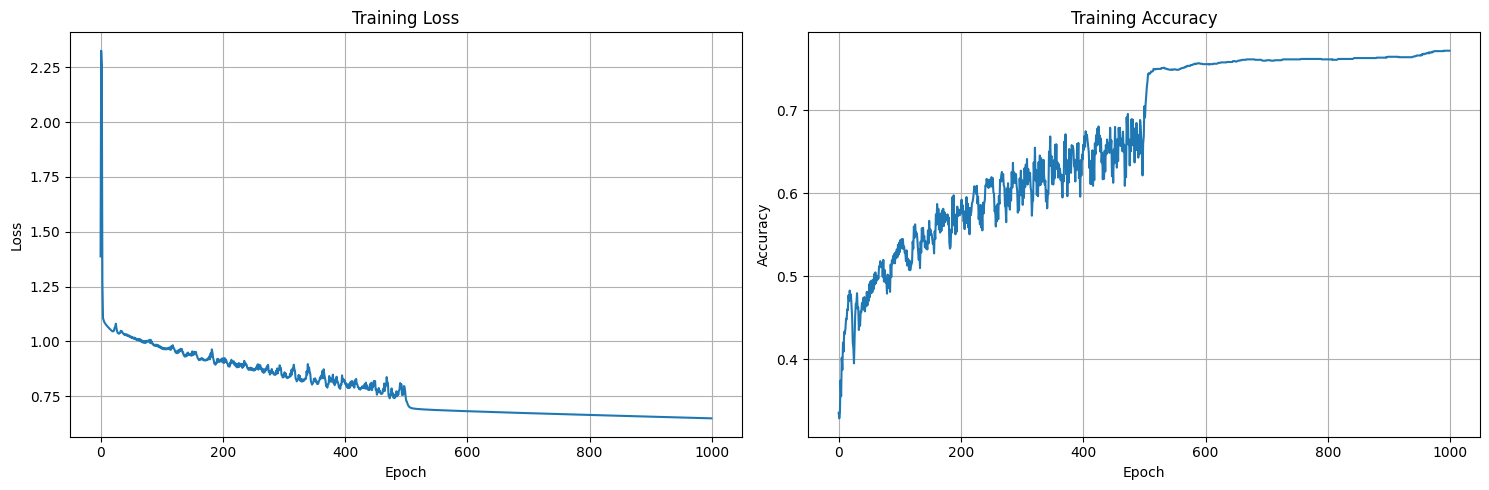

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss
ax1.plot(losses)
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Plot training accuracy
ax2.plot(accuracies)
ax2.set_title("Training Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Evaluate


In [11]:
y_pred = nn.predict(X_test)
y_true = np.argmax(y_test, axis=1)

acc = np.mean(y_pred == y_true)
print(f"Test Accuracy: {acc:.3f}")



Test Accuracy: 0.571


# Confusion matrix


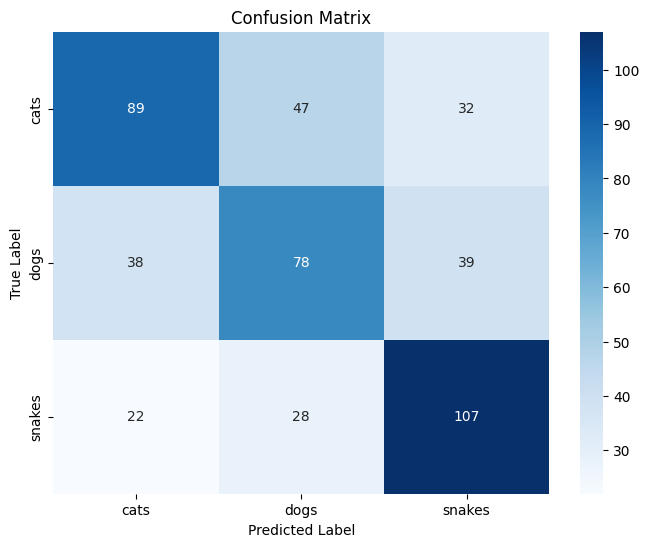

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dirs, yticklabels=dirs)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [13]:
print(classification_report(y_true, y_pred, target_names=dirs))

              precision    recall  f1-score   support

        cats       0.60      0.53      0.56       168
        dogs       0.51      0.50      0.51       155
      snakes       0.60      0.68      0.64       157

    accuracy                           0.57       480
   macro avg       0.57      0.57      0.57       480
weighted avg       0.57      0.57      0.57       480

